In [2]:
import math
import os
import random
from eppy import modeleditor
from eppy.modeleditor import IDF
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from utilities import read_json, write_json

In [7]:
directory = '../../data/'
df_list = []

for cz_directory in os.listdir(directory):
    if 'Zone' in cz_directory:
        df = pd.read_csv(os.path.join(os.path.join(directory,cz_directory),'solar_generation_1kW.csv'))
        df.columns = ['year_hour','ac_inverter_power_per_kw']
        df['climate_zone'] = int(cz_directory.split('.')[0].split('_')[-1])
        df_list.append(df)

df = pd.concat(df_list,ignore_index=True)
df.to_csv('.misc/solar_generation_1kW.csv',index=False)

# Exploring ORNL Dataset
***

In [8]:
directory = '../data/idf/counties/TX_Austin'
settings_filepath = '.misc/settings.json'
settings = read_json(settings_filepath)

## Collate IDF Metadata

In [17]:
# NOTE: takes a while to run!
record_list = []
IDF.setiddname(settings['idd_filepath'])

for filename in os.listdir(directory):
    if filename.endswith('idf'):
        filepath = os.path.join(directory,filename)
        idf = IDF(filepath)
        record = {
            'id':filename.split('.')[0],
            'building_name':idf.idfobjects['BUILDING'][0]['Name'].split(' created')[0][1:],
            'zone_count':len(idf.idfobjects['ZONE']),
            'total_zone_area':sum([modeleditor.zonearea(idf,zone['Name']) for zone in idf.idfobjects['ZONE']]),
            'total_zone_floor_area':sum([modeleditor.zonearea_floor(idf,zone['Name']) for zone in idf.idfobjects['ZONE']]),
            'total_zone_volume':sum([modeleditor.zonevolume(idf,zone['Name']) for zone in idf.idfobjects['ZONE']]),
            'total_zone_roof_area':sum([modeleditor.zonearea_roofceiling(idf,zone['Name'],) for zone in idf.idfobjects['ZONE']])
        }
        record_list.append(record)
    else:
        continue

data = pd.DataFrame(record_list)
data.to_pickle(f'{os.path.join(directory,"summary.pkl")}')
display(data.head(5))

,building_name,id,total_zone_area,total_zone_floor_area,total_zone_roof_area,total_zone_volume,zone_count
0,MidriseApartment-ASHRAE 169-2006-2A,7003000517321,131.105882,131.105882,131.105882,75.127731,1
1,MidriseApartment-ASHRAE 169-2006-2A,7052012986519,121.191943,121.191943,121.191943,194.971189,1
2,MidriseApartment-ASHRAE 169-2006-2A,7052012793525,56.942844,56.942844,56.942844,94.418761,1
3,MidriseApartment-ASHRAE 169-2006-2A,7003000518012,128.076926,128.076926,128.076926,158.932754,1
4,MidriseApartment-ASHRAE 169-2006-2A,7052012987607,295.029715,295.029715,295.029715,522.870193,1


## Visualize IDF Metadata

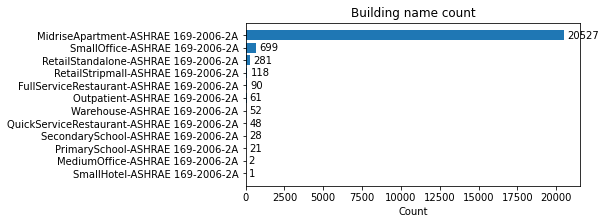

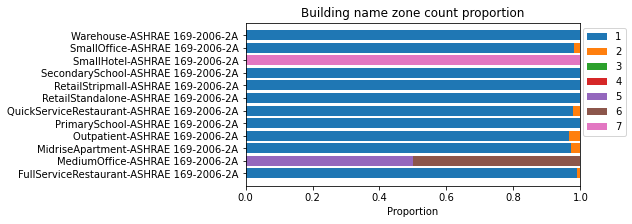

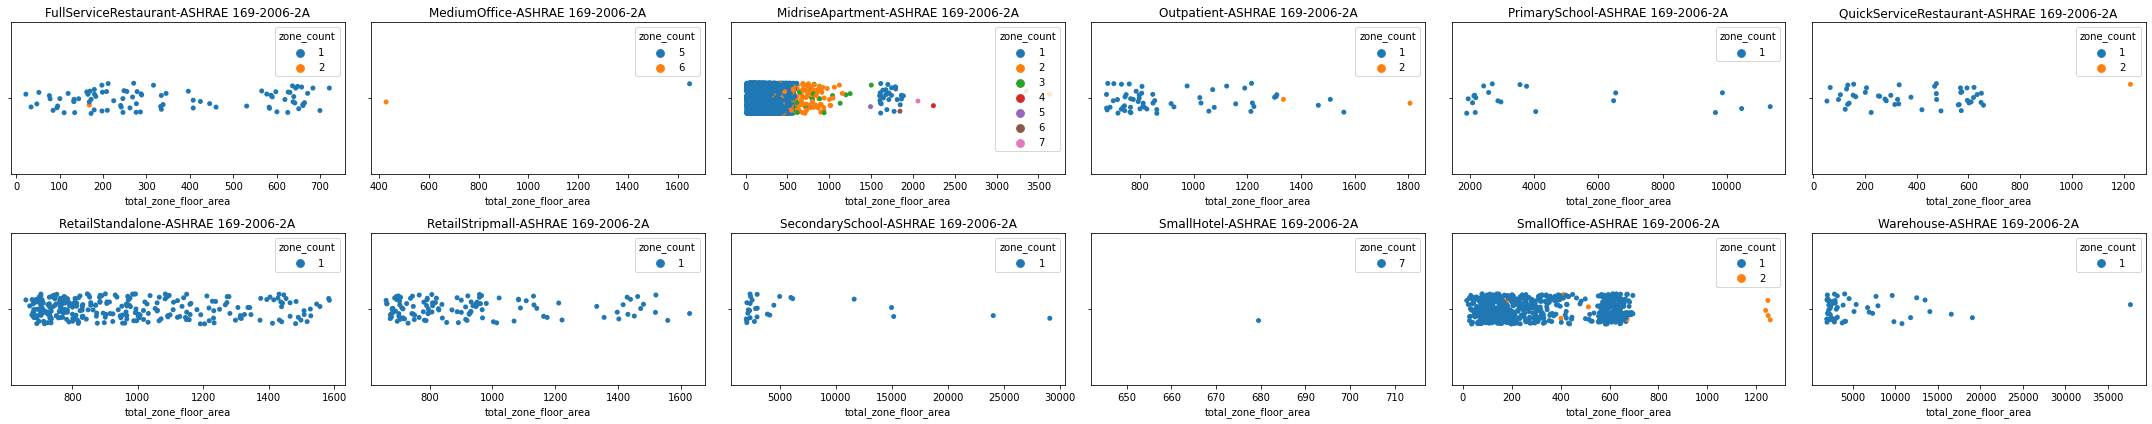

In [9]:
data = pd.read_pickle(os.path.join(directory,"summary.pkl"))

# building name count
fig, ax = plt.subplots(1,1,figsize=(6,3))
plot_data = data.groupby('building_name').size().reset_index(name='count')
plot_data = plot_data.sort_values('count',ascending=True)
rects = ax.barh(plot_data['building_name'],plot_data['count'])
ax.bar_label(rects,padding=3)
ax.set_xlabel('Count')
ax.set_title('Building name count')
plt.show()

# zone count proportion
plot_data = data.groupby(['building_name','zone_count']).size().reset_index(name='count')
totals = data.groupby('building_name').size().reset_index(name='total_count')
plot_data = pd.merge(plot_data,totals,on='building_name',how='left')
plot_data['proportion'] = plot_data['count']/plot_data['total_count']
plot_data = plot_data.pivot(index='building_name',columns='zone_count',values='proportion')
fig, ax = plt.subplots(1,1,figsize=(6,3))

for i in range(plot_data.shape[1]):
    if i == 0:
        ax.barh(plot_data.index,plot_data.iloc[:,i],label=i+1)
    else:
        bottom = plot_data.iloc[:,0:i].sum(axis=1,min_count=0).values
        ax.barh(plot_data.index,plot_data.iloc[:,i],left=bottom,label=i+1)

ax.legend(loc='upper right',bbox_to_anchor=(1.15,1))
ax.set_xlabel('Proportion')
ax.set_title('Building name zone count proportion')
plt.show()

# floor area distribution
column_count_limit = 6
series_count = len(data['building_name'].unique())
row_count = math.ceil(series_count/column_count_limit)
ax_size = (5,3)
fig, axs = plt.subplots(
    row_count,
    column_count_limit,
    figsize=(ax_size[0]*column_count_limit,ax_size[1]*row_count),
)

for ax, (name, group) in zip(fig.axes,data.groupby('building_name')):
    sns.stripplot(x='total_zone_floor_area',y='building_name',hue='zone_count',data=group,ax=ax)
    ax.set_yticklabels([None])
    ax.set_ylabel(None)
    ax.set_title(name)

plt.tight_layout()
plt.show()

## Single-Family Buildings
Assume buildings with $1500ft^2 \le$ total floor area $\le 2500ft^2$ are single-family homes. We will select 300 of such buildings that have 1 thermal zone at random to use in creating new input buildings for CityLearn.

In [19]:
sf_data = data[
    (data['building_name']=='MidriseApartment-ASHRAE 169-2006-2A')
    &(data['total_zone_floor_area']>=1500/10.7639)
    &(data['total_zone_floor_area']<=2500/10.7639)
].copy()
print(f'Single-family home count: {sf_data.shape[0]}')

sample_count = 300
random.seed(0)
ids = sf_data[sf_data['zone_count']==1]['id'].unique().tolist()
print(f'Single-family home with 1 thermal zone count: {len(ids)}')

ids = sorted(ids)
ids = random.sample(ids,sample_count)
print(f'Randomly selected single-family homes count: {len(ids)}')
selected = [{'idf_filepath':f'{os.path.join("TX_Austin",f"{id_}.idf")}','building_type':5,'climate_zone':2} for id_ in ids]
filepath = '../data/idf/selected.json'

if os.path.isfile(filepath):
    selected += read_json(filepath)
    selected = pd.DataFrame(selected).drop_duplicates()
    selected = selected.to_dict(orient='records')
    
else:
    pass

write_json(filepath,selected)

Single-family home count: 6058
Single-family home with 1 thermal zone count: 5943
Randomly selected single-family homes count: 300


# E+ Model Questions
-  `need to set to ideal loads?`
- `To use rate/energy variable?`
    - Using energy and converting to kWh by dividing by (3600 * 1000)
- `need to use appropriate weather file for design day?`
    - Using [this](https://unmethours.com/question/38233/energy-plus-eppy-scripting-design-day-problem/) approach.
- `What is the correct object to use to get cooling load?`
- `What load schedules are defined in the models?`
    - People density & activity level, equipment, lighting, cooling/heating setpoints, infiltration
- `Is number of zones same as number of floors?`
    - Not always, it can be a single floor but a larger floor area causes it to be split into multiple zones (See 7052012804616.osm for example). Also, only 1 zone in the multiple zone buildings (2 zones) has HVAC system objects and it ha double definitions so I suspect it was a mistake in generating the models where the equipment for the other thermal zone were assigned to the other zone.
- `need to add domestic hot water object?`
    Yes and a schedule as well as there is noe defined in the schedules object list. See [here](https://bigladdersoftware.com/epx/docs/8-0/input-output-reference/page-025.html) for hot water object specifications.
- `how to check if building has PV installed?`
    - I guess we don't really care to install PVs in the actual energy model. We just need a profile of solar generated power over the episode and use that to offset the cooling, heating and hot water loads.
- `how to install PV?`
    - See answer above.
- `how to decide solar panel sizing for building?`
    - Design for which ever is less between timestep peak load and solar energy while considering roof area?
- `should the difference between setpoint and air temperature be absolute?`
    - There are no negative values in the existing building timeseries files so must be absolute.
- `how are heating loads dealt with? Negative cooling load?`
    - No negative cooling loads values in existing building timeseries so not sure how heating load is accounted for or are the buildings not heated in the winter?
- `what is building type field in building attributes used for in CityLearn simulation?`

# Questions
***
1. `What does day type field in building data represent?`
    - It is day of week index using Energy Plus indexing (1-8, where 1-7 are Sun-Sat & 8 is holiday)
2. `What is Average Unmet Cooling Setpoint Difference [C]?`
    - Average difference between setpoint and zone temperature across all building thermal zones weighted by floor area.
2. `How are Indoor Temperature [C] and Indoor Relative Humidity [%] calculated?`
    - Indoor Temperature [C] and Indoor Relative Humidity [%] are weighted averages w.r.t. floor area.
3. `How do residential buildings 5-9 (medium multi-family) they differ? Different structural properties, size, or just load profiles?`
    - Seems like it's the same building structurally but hot water and plug loads are varied

# Adding New Residential Buildings
***
## Summary
Current CityLearn environment has 5 residential buildings that are alike in termns of envelope parameters and geometry but differ in non-shiftable load schedule and domestic hot water demand schedule. We want to revise the environment so that we can simulate a residential district that has the same load as that served by 1 transformer in reality. This amounts to 200-300 buildings but we must make sure there is a variance in how the buildings behave energy-wise. We also want single-family homes. Once we have the simulation results of the buildings, we just need to represent the results in the schema used for [building data](https://github.com/intelligent-environments-lab/CityLearn/tree/master/data/Climate_Zone_1) in CityLearn and update the [building_attributes.json](https://github.com/intelligent-environments-lab/CityLearn/blob/master/data/Climate_Zone_1/building_attributes.json) accordingly.

## Option 1
One way to go about this is to adopt the existing implementation made by Jose where we use the same building but vary load schedules to a create variance amongst buildings. 
#### Questions
1. Where is the source code that generates the different load schedules from Jose if we choose this option.

## Option 2
A second option is to use the energy model dataset provided by [ORNL](https://www.osti.gov/dataexplorer/biblio/dataset/1774134) which provides energy models for all buildings in a city, _accurate to some degree_. We will need to pick a residential neighborhood in Austin from this dataset that generalizes well with other residential neighborhoods. We can also pick 3 neighborhoods based on income level i.e. low, medium and high to make the results even more interesting. The level of detail in the models is unknown. To get a summary of the model parameter, we will need to find a way to parse the IDF files and extract model data into JSON. There may be Python libraries out there that parse IDF. Once we have a summary of the models, we can learn about how detailed they are and then decide on what needs to be tweaked. 

#### Questions
1. What existing publications have made use of the dataset and have some background information on what to expect?